# Training the Neural Network

Let's try using a U-Net for image segmentation (original paper: https://arxiv.org/abs/1505.04597, starter notebook: https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277/notebook)

## Load in training and testing data

`data.py` file

In [1]:
import numpy as np
import pydicom as dicom
import os
from glob import glob
import scipy.ndimage
import re
import sys
from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images

def natural_sort(l): 
    convert = lambda text: int(text) if text.isdigit() else text.lower() 
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(l, key = alphanum_key)

def load_scan(path):
    #slices = [dicom.read_file((path + '/' + s) for s in os.listdir(path))]
    slices = []
    for file in glob(path + '/*.DCM'):
        slices.append(dicom.read_file(file))
    slices.sort(key = lambda x: int(x.InstanceNumber)) # sort by slice number
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

def show_dcm_info(dataset, path):
    print("Filename.........:", path)
    print("Storage type.....:", dataset.SOPClassUID)
    print()

    pat_name = dataset.PatientName
    display_name = pat_name.family_name + ", " + pat_name.given_name
    print("Patient's name......:", display_name)
    print("Patient id..........:", dataset.PatientID)
    print("Patient's Age.......:", dataset.PatientAge)
    print("Patient's Sex.......:", dataset.PatientSex)
    print("Modality............:", dataset.Modality)
    print("Body Part Examined..:", dataset.BodyPartExamined)
    if 'ViewPosition' in dataset:
        print("View Position.......:", dataset.ViewPosition)
    
    if 'PixelData' in dataset:
        rows = int(dataset.Rows)
        cols = int(dataset.Columns)
        print("Image size.......: {rows:d} x {cols:d}, {size:d} bytes".format(
            rows=rows, cols=cols, size=len(dataset.PixelData)))
        if 'PixelSpacing' in dataset:
            print("Pixel spacing....:", dataset.PixelSpacing)

def get_pixels(scans):
    image = np.stack([s.pixel_array for s in scans])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)
    
    return np.array(image, dtype=np.int16)

def sample_stack(stack, rows=4, cols=5, start_with=0, show_every=1):
    fig,ax = plt.subplots(rows,cols,figsize=[12,12])
    ind = start_with
    for i in range(rows):
        for j in range(cols):
            ax[i,j].set_title('slice %d' % (ind+1))
            ax[i,j].imshow(stack[ind],cmap='gray')
            ax[i,j].axis('off')
            ind = ind + show_every
    plt.show()

def get_data(TRAIN_PATH,TEST_PATH,IMG_WIDTH,IMG_HEIGHT,NUM_SLICES,IMG_CHANNELS):
    # Get train and test IDs
    train_ids = next(os.walk(TRAIN_PATH+'imgs/'))[2]
    test_ids = next(os.walk(TEST_PATH+'imgs/'))[2]

    # Get and resize train images and masks
    #print('Getting train images and masks ... ')
    X_train = np.zeros((len(train_ids)*NUM_SLICES, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint16)
    y_train = np.zeros((len(train_ids)*NUM_SLICES, IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
        i = 0
        path = TRAIN_PATH + 'imgs/' + id_
        img = np.load(path)[:,:,:,np.newaxis]
        mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
        maskpath = TRAIN_PATH + 'labels/' + id_
        mask_ = np.load(maskpath)[:,:,:,np.newaxis]
        mask = np.maximum(mask, mask_)
        for i in range(NUM_SLICES):
            X_train[n*NUM_SLICES + i] = img[i]
            y_train[n*NUM_SLICES + i] = mask[i]
            i+=1

    # Get and resize test images
    #print('Getting test images and masks ... ')
    X_test = np.zeros((len(test_ids)*NUM_SLICES, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint16)
    y_test = np.zeros((len(test_ids)*NUM_SLICES, IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    sizes_test = []
    for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
        i = 0
        path = TEST_PATH + 'imgs/' + id_
        img = np.load(path)[:,:,:,np.newaxis]
        sizes_test.append([img.shape[0], img.shape[1]])
        mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
        maskpath = TEST_PATH + 'labels/' + id_
        mask_ = np.load(maskpath)[:,:,:,np.newaxis]
        mask = np.maximum(mask, mask_)
        for i in range(NUM_SLICES):
            X_test[n*NUM_SLICES + i] = img[i]
            y_test[n*NUM_SLICES + i] = mask[i]
            i+=1
    print('Done!')

    return (X_train, X_test, y_train, y_test)

In [2]:
# Parameters
width = 256
height = 256
slices = 20
channels = 1
trainpath = './train/'
testpath = './test/'

(X_train, X_test, y_train, y_test) = get_data(trainpath, testpath, width, height, slices, channels)

100%|██████████| 8/8 [00:00<00:00, 203.91it/s]

Done!


## Set up model

`model.py` file

In [14]:
from keras.models import Model, load_model, model_from_json
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

# define metrics

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [4]:
# Build U-Net model
def unet(width, height, channels, pretrained_weights = None):
    inputs = Input((width, height, channels))
    s = Lambda(lambda x: x / 255) (inputs) 

    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (s)
    c1 = Dropout(0.1) (c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p1)
    c2 = Dropout(0.1) (c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p2)
    c3 = Dropout(0.2) (c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p3)
    c4 = Dropout(0.2) (c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p4)
    c5 = Dropout(0.3) (c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c5)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u6)
    c6 = Dropout(0.2) (c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u7)
    c7 = Dropout(0.2) (c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u8)
    c8 = Dropout(0.1) (c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u9)
    c9 = Dropout(0.1) (c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer=Adam(lr = 1e-4), loss='binary_crossentropy', metrics=[dice_coef,'accuracy'])
    if(pretrained_weights):
        model.load_weights(pretrained_weights)
    model.summary()

    return model

## Run model

First check if any pretrained weights exist, then run the training

In [5]:
if os.path.exists('./model-1.h5'):
    weights = './model-1.h5'
    model = unet(width, height, channels, weights)
else:
    model = unet(width, height, channels)

# Fit model
es = EarlyStopping(patience=5, verbose=1)
mc = ModelCheckpoint('model-1.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, y_train, validation_split=0.2, batch_size=16, epochs=50, 
                    callbacks=[es, mc])


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 256, 256, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 160         lambda_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 256, 256, 16) 0           conv2d_1[0][0]                 


Train on 528 samples, validate on 132 samples
Epoch 1/50
528/528 [==============================] - 6s 12ms/step - loss: 0.0913 - dice_coef: 0.1042 - accuracy: 0.9761 - val_loss: 0.0824 - val_dice_coef: 0.1242 - val_accuracy: 0.9763

Epoch 00001: val_loss improved from inf to 0.08236, saving model to model-1.h5
Epoch 2/50
528/528 [==============================] - 3s 6ms/step - loss: 0.0834 - dice_coef: 0.1240 - accuracy: 0.9763 - val_loss: 0.0761 - val_dice_coef: 0.1313 - val_accuracy: 0.9763

Epoch 00002: val_loss improved from 0.08236 to 0.07613, saving model to model-1.h5
Epoch 3/50
528/528 [==============================] - 3s 6ms/step - loss: 0.0780 - dice_coef: 0.1348 - accuracy: 0.9764 - val_loss: 0.0760 - val_dice_coef: 0.1363 - val_accuracy: 0.9763

Epoch 00003: val_loss improved from 0.07613 to 0.07599, saving model to model-1.h5
Epoch 4/50
528/528 [==============================] - 3s 6ms/step - loss: 0.0755 - dice_coef: 0.1432 - accuracy: 0.9764 - val_loss: 0.0807 - val_d

528/528 [==============================] - 3s 6ms/step - loss: 0.0224 - dice_coef: 0.7073 - accuracy: 0.9911 - val_loss: 0.0324 - val_dice_coef: 0.5594 - val_accuracy: 0.9874

Epoch 00032: val_loss did not improve from 0.02981
Epoch 33/50
528/528 [==============================] - 3s 6ms/step - loss: 0.0221 - dice_coef: 0.7110 - accuracy: 0.9911 - val_loss: 0.0486 - val_dice_coef: 0.4962 - val_accuracy: 0.9856

Epoch 00033: val_loss did not improve from 0.02981
Epoch 34/50
528/528 [==============================] - 3s 6ms/step - loss: 0.0220 - dice_coef: 0.7160 - accuracy: 0.9910 - val_loss: 0.0321 - val_dice_coef: 0.5548 - val_accuracy: 0.9878

Epoch 00034: val_loss did not improve from 0.02981
Epoch 35/50
528/528 [==============================] - 3s 6ms/step - loss: 0.0213 - dice_coef: 0.7216 - accuracy: 0.9913 - val_loss: 0.0413 - val_dice_coef: 0.5016 - val_accuracy: 0.9847

Epoch 00035: val_loss did not improve from 0.02981
Epoch 00035: early stopping


Validation loss doesn't appear to be improving at all for some runs - may be dependent on which slices end up in the validation set as there are many blank ones without any vertebrae classified

In [8]:
results.history.keys()

dict_keys(['val_loss', 'val_dice_coef', 'val_accuracy', 'loss', 'dice_coef', 'accuracy'])

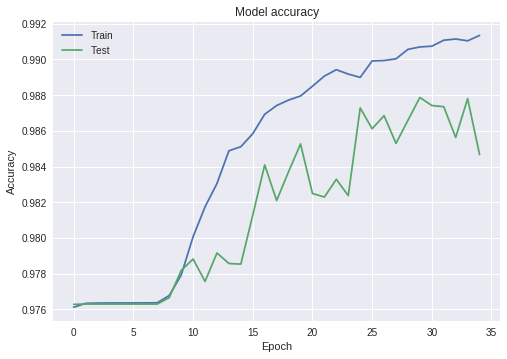

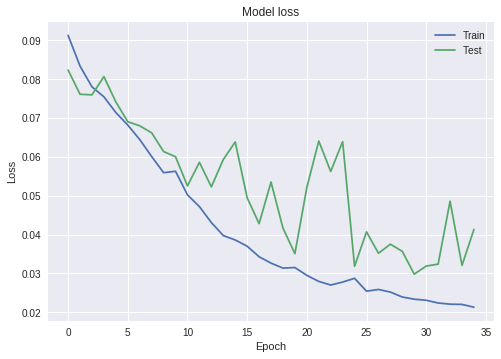

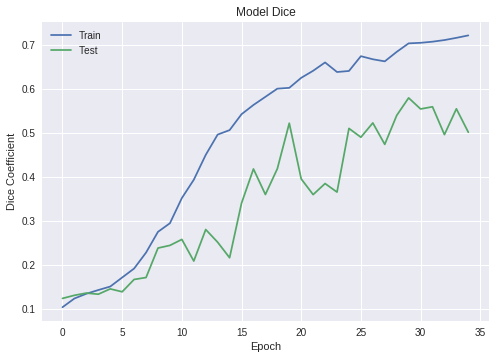

In [11]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# Plot training & validation accuracy values
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

# Plot training & validation dice coefficients
plt.plot(results.history['dice_coef'])
plt.plot(results.history['val_dice_coef'])
plt.title('Model Dice')
plt.ylabel('Dice Coefficient')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Nevertheless, the NN seems to be doing alright, though early stopping kicked in after 35 epochs. Let's run it for a bit longer with a bit more patience!

In [12]:
es = EarlyStopping(patience=50, verbose=1)
mc = ModelCheckpoint('model-1.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, y_train, validation_split=0.2, batch_size=4, epochs=500, 
                    callbacks=[es, mc])

Train on 528 samples, validate on 132 samples
Epoch 1/500
528/528 [==============================] - 4s 8ms/step - loss: 0.0275 - dice_coef: 0.5324 - accuracy: 0.9893 - val_loss: 0.0286 - val_dice_coef: 0.3601 - val_accuracy: 0.9878

Epoch 00001: val_loss improved from inf to 0.02863, saving model to model-1.h5
Epoch 2/500
528/528 [==============================] - 4s 7ms/step - loss: 0.0241 - dice_coef: 0.5695 - accuracy: 0.9906 - val_loss: 0.0289 - val_dice_coef: 0.3590 - val_accuracy: 0.9883

Epoch 00002: val_loss did not improve from 0.02863
Epoch 3/500
528/528 [==============================] - 4s 7ms/step - loss: 0.0223 - dice_coef: 0.5795 - accuracy: 0.9911 - val_loss: 0.0253 - val_dice_coef: 0.3848 - val_accuracy: 0.9891

Epoch 00003: val_loss improved from 0.02863 to 0.02534, saving model to model-1.h5
Epoch 4/500
528/528 [==============================] - 4s 7ms/step - loss: 0.0208 - dice_coef: 0.6281 - accuracy: 0.9918 - val_loss: 0.0285 - val_dice_coef: 0.3896 - val_accurac

528/528 [==============================] - 4s 7ms/step - loss: 0.0085 - dice_coef: 0.7496 - accuracy: 0.9966 - val_loss: 0.0236 - val_dice_coef: 0.5452 - val_accuracy: 0.9932

Epoch 00034: val_loss did not improve from 0.01849
Epoch 35/500
528/528 [==============================] - 4s 7ms/step - loss: 0.0085 - dice_coef: 0.7401 - accuracy: 0.9966 - val_loss: 0.0247 - val_dice_coef: 0.5465 - val_accuracy: 0.9923

Epoch 00035: val_loss did not improve from 0.01849
Epoch 36/500
528/528 [==============================] - 4s 8ms/step - loss: 0.0089 - dice_coef: 0.7694 - accuracy: 0.9965 - val_loss: 0.0221 - val_dice_coef: 0.5598 - val_accuracy: 0.9931

Epoch 00036: val_loss did not improve from 0.01849
Epoch 37/500
528/528 [==============================] - 4s 8ms/step - loss: 0.0087 - dice_coef: 0.7580 - accuracy: 0.9965 - val_loss: 0.0228 - val_dice_coef: 0.6024 - val_accuracy: 0.9934

Epoch 00037: val_loss did not improve from 0.01849
Epoch 38/500
528/528 [==============================]

528/528 [==============================] - 4s 8ms/step - loss: 0.0039 - dice_coef: 0.8897 - accuracy: 0.9984 - val_loss: 0.0296 - val_dice_coef: 0.8549 - val_accuracy: 0.9941

Epoch 00102: val_loss did not improve from 0.01711
Epoch 103/500
528/528 [==============================] - 4s 7ms/step - loss: 0.0039 - dice_coef: 0.9095 - accuracy: 0.9984 - val_loss: 0.0302 - val_dice_coef: 0.8338 - val_accuracy: 0.9941

Epoch 00103: val_loss did not improve from 0.01711
Epoch 104/500
528/528 [==============================] - 4s 7ms/step - loss: 0.0038 - dice_coef: 0.9016 - accuracy: 0.9984 - val_loss: 0.0307 - val_dice_coef: 0.8370 - val_accuracy: 0.9939

Epoch 00104: val_loss did not improve from 0.01711
Epoch 105/500
528/528 [==============================] - 4s 7ms/step - loss: 0.0038 - dice_coef: 0.9227 - accuracy: 0.9984 - val_loss: 0.0336 - val_dice_coef: 0.8670 - val_accuracy: 0.9941

Epoch 00105: val_loss did not improve from 0.01711
Epoch 106/500
528/528 [===========================

Early stopping after 122 epochs - let's see the loss history again:

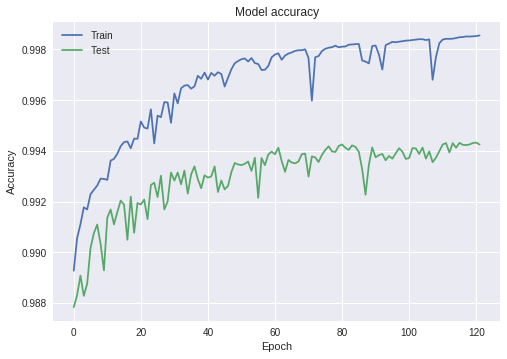

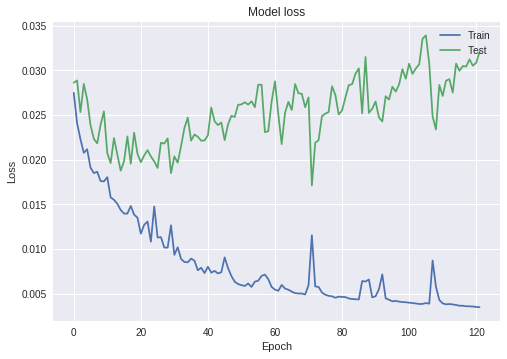

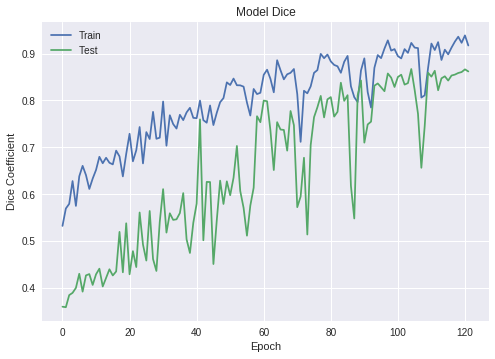

In [13]:
# Plot training & validation accuracy values
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

# Plot training & validation dice coefficients
plt.plot(results.history['dice_coef'])
plt.plot(results.history['val_dice_coef'])
plt.title('Model Dice')
plt.ylabel('Dice Coefficient')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Save the model

In [15]:
model_json = model.to_json()
with open("model-1.json", "w") as json_file:
    json_file.write(model_json)